In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path='/content/drive/MyDrive/pls_isl_conflict_comments.xlsx'
data = pd.read_excel(file_path, na_filter=False, names=['comment_id', 'score', 'self_text', 'subreddit', 'created_time'])
data = data[['comment_id', 'score', 'self_text', 'subreddit', 'created_time']]
data.head(10)

,comment_id,score,self_text,subreddit,created_time
0,k5480sx,1,Exactly! I can remember the humanitarian aid s...,worldnews,2023-10-16 19:39:00
1,k547q14,1,*We are the only part of the World that has Fr...,Palestine,2023-10-16 19:36:00
2,k547elf,1,"I don_x0019_t make Israeli strategy, nor am I ...",worldnews,2023-10-16 19:34:00
3,k54742r,1,These people didn't vote Hamas in or something...,worldnews,2023-10-16 19:32:00
4,k5473zi,1,We don't care what you do. We just want to liv...,worldnews,2023-10-16 19:32:00
5,k546z8v,1,Hamas exists because of the Israeli control of...,IsraelPalestine,2023-10-16 19:31:00
6,k546wh4,1,I'll forward it when I have time to find it. ...,IsraelPalestine,2023-10-16 19:31:00
7,k546uqt,1,You can inverte the flags and its gonna still ...,Palestine,2023-10-16 19:30:00
8,k546upe,1,I wish the media would talk more about the par...,worldnews,2023-10-16 19:30:00
9,k546sze,1,They are blinded by social media fake news. Th...,IsraelPalestine,2023-10-16 19:30:00


In [7]:
print("Dataset shape:", data.shape)

Dataset shape: (190396, 5)


In [8]:
df = pd.DataFrame(data, columns=["comment_id", "score", "self_text", "subreddit", "created_time"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190396 entries, 0 to 190395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    190384 non-null  object
 1   score         190396 non-null  object
 2   self_text     190198 non-null  object
 3   subreddit     190396 non-null  object
 4   created_time  190396 non-null  object
dtypes: object(5)
memory usage: 7.3+ MB


In [9]:
print(df['self_text'].isnull().sum())

198


In [10]:
columns_to_drop = ['comment_id', 'score', 'subreddit', 'created_time']
data['self_text'] = data['self_text'].astype('str')
df.drop(columns=columns_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190396 entries, 0 to 190395
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   self_text  190198 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [11]:
# Install the required libraries
!pip install nltk
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Set the threshold for binary classification
threshold = 0.1

# Function to get the binary polarity (1 or 0) for a given text
def get_binary_polarity(text):
    if isinstance(text, str):
        compound_score = analyzer.polarity_scores(text)['compound']
        return 1 if compound_score >= threshold else 0
    else:
        return 0  # or any other default value for non-string values

df['polarity'] = df['self_text'].apply(get_binary_polarity)

print(df.head(15))
df.info()
print(df['polarity'].unique())


                                            self_text  polarity
0   Exactly! I can remember the humanitarian aid s...         1
1   *We are the only part of the World that has Fr...         1
2   I don_x0019_t make Israeli strategy, nor am I ...         1
3   These people didn't vote Hamas in or something...         0
4   We don't care what you do. We just want to liv...         0
5   Hamas exists because of the Israeli control of...         1
6   I'll forward it when I have time to find it.  ...         1
7   You can inverte the flags and its gonna still ...         0
8   I wish the media would talk more about the par...         0
9   They are blinded by social media fake news. Th...         0
10  It_x0019_s what you meant.   Why do people wan...         0
11  Yeah, he already knew that and does not suppor...         0
12  It's the middle of a funking war do you unders...         0
13  No.  Hamas put their base of operations intent...         0
14  It's messed up people can't comprehe

In [13]:
(df.isnull().sum() / len(data))*100

data['self_text'] = data['self_text'].astype('str')

In [14]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

{'each', 'under', 'on', "shouldn't", 'where', 'ours', 'once', 'she', 'it', 'be', 'don', "shan't", 'had', 'doing', 'yourself', 'same', 'wasn', 'up', 'very', 's', 'been', 'yours', 'for', 'our', 'were', 'in', 'mustn', 'needn', 'not', 'ain', 'that', "hadn't", 'should', 'here', "won't", 'over', 'wouldn', 'both', 'or', 'nor', "couldn't", "doesn't", "isn't", 'a', 'before', 'at', 'itself', 'above', 'than', 'these', 'to', 'shouldn', 'this', 'being', "you've", 'its', "mustn't", 'am', "weren't", 'whom', 'because', 'of', 'when', 'is', 'haven', 'ourselves', "needn't", 'hers', 'are', 'who', 'does', 've', 'the', 'have', "it's", 't', 'and', 'doesn', 'has', 'him', 'do', 'but', 'after', 'd', 'yourselves', 'off', 'theirs', 'he', 'such', "should've", 'their', 'can', 'was', 'hasn', 'an', 'those', 'o', 'few', 'just', 'until', 'y', 'most', 'i', 'herself', 'won', 'my', 'why', 'shan', 'did', 'weren', "that'll", 'so', 'his', 'm', 'all', 'your', 'having', 'hadn', 'other', 'from', 'no', 'about', "wouldn't", 'into

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

stopword = set(stopwords.words('english'))

def process_tweets(tweet):
    if isinstance(tweet, str):
        # Lowercasing
        tweet = tweet.lower()
        tweet = tweet[1:]
        # Removing URLs
        tweet = re.sub(urlPattern, '', tweet)
        # Removing @usernames
        tweet = re.sub(userPattern, '', tweet)
        # Remove punctuations
        tweet = tweet.translate(str.maketrans("", "", string.punctuation))
        # Tokenizing words
        tokens = word_tokenize(tweet)
        # Removing stop words
        final_tokens = [w for w in tokens if w not in stopword]
        # Reducing a word to its word stem
        wordLemm = WordNetLemmatizer()
        finalwords = [wordLemm.lemmatize(w) for w in final_tokens if len(w) > 1]

        return ' '.join(finalwords)
    else:
        return ''  # or any other default value for non-string values

df['processed_tweets'] = df['self_text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

df.head(10)


Text Preprocessing complete.


,self_text,polarity,processed_tweets
0,Exactly! I can remember the humanitarian aid s...,1,xactly remember humanitarian aid streaming ste...
1,*We are the only part of the World that has Fr...,1,part world freedom speech person exercise free...
2,"I don_x0019_t make Israeli strategy, nor am I ...",1,donx0019t make israeli strategy israeli jewish...
3,These people didn't vote Hamas in or something...,0,hese people didnt vote hamas something cant ex...
4,We don't care what you do. We just want to liv...,0,dont care want live world literally impossible...
5,Hamas exists because of the Israeli control of...,1,amas exists israeli control area itx0019s occu...
6,I'll forward it when I have time to find it. ...,1,forward time find interview saw weekend believ...
7,You can inverte the flags and its gonna still ...,0,ou inverte flag gon na still right stop think ...
8,I wish the media would talk more about the par...,0,wish medium would talk particular abuse afflic...
9,They are blinded by social media fake news. Th...,0,hey blinded social medium fake news changed si...


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['processed_tweets'].values
y = df['polarity'].values
print(X.shape)
print(y.shape)

vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')

print(X.shape)
print(y.shape)

(190396,)
(190396,)
Vector fitted.
(190396, 90155)
(190396,)


In [18]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.processed_tweets)
sequences = tokenizer.texts_to_sequences(df.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  260   46  863]
 [   0    0    0 ... 1168    5 1004]
 [   0    0    0 ... 4525  309   22]
 ...
 [   0    0    0 ...  224  929   26]
 [   0    0    0 ...   28 4981  104]
 [ 490 1307   32 ...   23  617 4018]]


In [19]:
X_train, X_test, y_train, y_test = train_test_split(tweets, df.polarity.values, test_size = 0.2, random_state=42)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (152316, 100)
y_train (152316,)

X_test (38080, 100)
y_test (38080,)


In [20]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(layers.Embedding(max_words, 128))
model.add(layers.LSTM(64,dropout=0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history=model.fit(X_train,y_train,epochs=14,batch_size= 64,validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 690593 (2.63 MB)
Trainable params: 690593 (2.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/14
2380/2380

In [21]:
res = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(res[0],res[1]))

1190/1190 [==============================] - 6s 5ms/step - loss: 0.2810 - accuracy: 0.8971
Test set
  Loss: 0.281
  Accuracy: 0.897


In [22]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.25).astype(int)

# Handle one-dimensional arrays
if len(y_test.shape) > 1:
    y_test_int = np.argmax(y_test, axis=1)
else:
    y_test_int = y_test

conf_matrix = confusion_matrix(y_test_int, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_test_int, y_pred)
print("\nAccuracy:", accuracy)

class_report = classification_report(y_test_int, y_pred)
print("\nClassification Report:")
print(class_report)


1190/1190 [==============================] - 5s 3ms/step

Confusion Matrix:
[[23546  2833]
 [ 1612 10089]]

Accuracy: 0.8832720588235294

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     26379
           1       0.78      0.86      0.82     11701

    accuracy                           0.88     38080
   macro avg       0.86      0.88      0.87     38080
weighted avg       0.89      0.88      0.88     38080



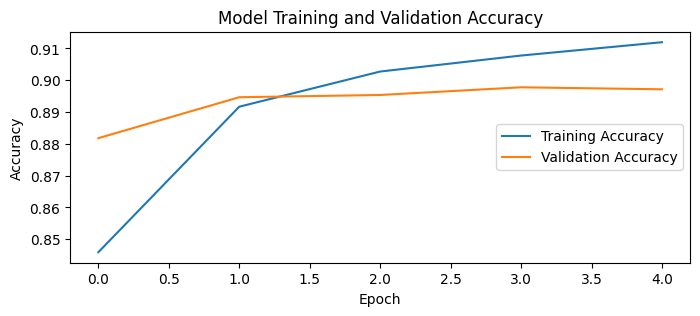

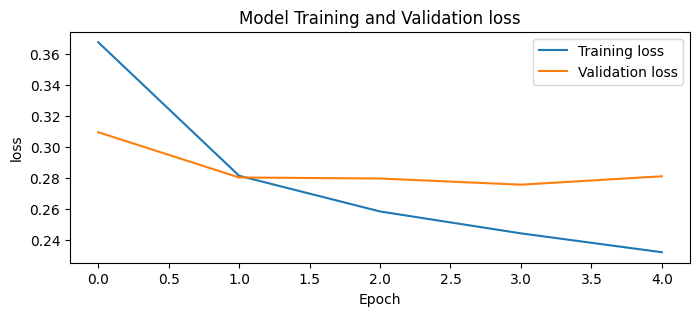

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8,3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='right')
plt.show()

fig = plt.figure(figsize=(8,3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [24]:
from keras.models import load_model
import numpy as np

custom_tweet = "xactly remember humanitarian aid streaming stepanekert week ago like streamed mariupol last year raqqa mosul year ago even let delve history moment humanitarian aid streamed stalingrad leningrad back ww2" #1

# Preprocess the custom tweet using the same tokenizer
custom_sequence = tokenizer.texts_to_sequences([custom_tweet])
custom_padded_sequence = pad_sequences(custom_sequence, maxlen=max_len)

prediction = model.predict(np.array(custom_padded_sequence))

# Model predicts binary sentiment (0 for negative, 1 for positive)
sentiment = "Positive" if prediction[0][0] > 0.25 else "Negative"

print(f"Custom Tweet: {custom_tweet}")
print(f"Predicted Sentiment: {sentiment} (Probability: {prediction[0][0]})")


1/1 [==============================] - 1s 601ms/step
Custom Tweet: xactly remember humanitarian aid streaming stepanekert week ago like streamed mariupol last year raqqa mosul year ago even let delve history moment humanitarian aid streamed stalingrad leningrad back ww2
Predicted Sentiment: Positive (Probability: 0.9349328279495239)


In [25]:
from keras.models import load_model
import numpy as np

custom_tweet = "ou inverte flag gon na still right stop think since part disgusting thing past start fking think future possibile compromise care people obviusly otherwise keep pushing one side propaganda sure another guy another subreddit pushing side one" #0
# Preprocess the custom tweet using the same tokenizer
custom_sequence = tokenizer.texts_to_sequences([custom_tweet])
custom_padded_sequence = pad_sequences(custom_sequence, maxlen=max_len)

prediction = model.predict(np.array(custom_padded_sequence))

# Model predicts binary sentiment (0 for negative, 1 for positive)
sentiment = "Positive" if prediction[0][0] > 0.25 else "Negative"

print(f"Custom Tweet: {custom_tweet}")
print(f"Predicted Sentiment: {sentiment} (Probability: {prediction[0][0]})")


1/1 [==============================] - 0s 22ms/step
Custom Tweet: ou inverte flag gon na still right stop think since part disgusting thing past start fking think future possibile compromise care people obviusly otherwise keep pushing one side propaganda sure another guy another subreddit pushing side one
Predicted Sentiment: Negative (Probability: 0.015379277989268303)
